Fractional Cover and Wofs notebook
 output WBG layers to geotiff for VRT assemblage in  QGIS.

### 21-11-2017 BD

## import some modules

In [19]:
%matplotlib inline

In [20]:
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

#import module to work with rgb images
from PIL import Image

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)    

In [21]:
#alias the datacube to something more wieldy and pass a string for reporting purposes
dc = datacube.Datacube(app='dc-wofs-fc')

## define functions to load fractional cover green veg and bare soil, load wofs, and write datasets to netcdf

### define WOFs load function

In [22]:
def load_wofs(query):
    
    #Create a query to store spatiotemporal information from the previous landsat query
    wofs_query = query
    dcwofs = datacube.Datacube(config='/g/data/r78/dc_configs/wofscube.conf')
    
    wofs_data = dcwofs.load(product = 'wofs_albers', **wofs_query, fuse_func=ga_pq_fuser)
    print('loaded wofs for query'+str(query))

    return wofs_data

## rewritten wofs function

In [23]:
def wofs_water_or_land(wofs_data):
    '''written by Ness altered by bex so wofs value is not divided by the length of the time series,
    but by the amount of valid wofs scenes per pixel. Function now identifies water and dry land values
    Also changed from % to proportion (interval(0-1)).'''
    
    #Build new array with only clear wet observations (128) and clear land observations (0)
    wofs_landwatervalues_only = wofs_data.water
    #filter to just get the clear obs
    wofs_landwatervalues_only['wet']=wofs_landwatervalues_only.where(wofs_landwatervalues_only==128)
    wofs_landwatervalues_only['dry']=wofs_landwatervalues_only.where(wofs_landwatervalues_only==0)
    #count the number of times wofs flags each pixel as wet for this epoch
    wetcount = wofs_landwatervalues_only['wet'].count(dim='time')
    #count the number of times wofs flags each pixel as dry for this epoch
    drycount = wofs_landwatervalues_only['dry'].count(dim='time')
    #count the number of times wofs flags each pixel as valid (clear wet obs or dry land) for this epoch
    wetordry_totalcount = (wofs_landwatervalues_only['dry'].count(dim='time')+wofs_landwatervalues_only['wet'].count(dim='time'))
    #calculate the proportion of the epoch that wofs returns water obs and dry obs per pixel
    wet_proportion = (wofs_landwatervalues_only['wet'].count(dim='time')/(wofs_landwatervalues_only['wet'].count(dim='time')+wofs_landwatervalues_only['dry'].count(dim='time')))
    dry_proportion = (wofs_landwatervalues_only['dry'].count(dim='time')/(wofs_landwatervalues_only['wet'].count(dim='time')+wofs_landwatervalues_only['dry'].count(dim='time')))

    return wet_proportion, dry_proportion

### define Fractional Cover load function

In [24]:
#def load_fc(sensor,query,bands_of_interest): 
def load_fc(sensor,query): 
    '''loads fractional cover data for a sensor, masks using pq, then filters out no data vals (-1)
    function written 22-11-2017 based on dc v1.5.3 BexDunn
    update to select measurements of interest ##FIXME
    '''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'fc')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered no data vals'.format(product_name,mask_product))
            ###Filter out fractional cover nodata values (-1)
            ds=ds.where(ds!=-1)
            
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

## Functions to calculate count of exceedence of fractional cover

##### set thresholds here for green, bare

In [25]:
def calc_bare_soil_overthresh(fc,threshold=50.0):
    '''Calculate bare soil fraction values where bare soil fraction> set threshold. Inputs are fc array with BE and threshold value, 
    default threshold is 50. Band for baresoil>threshold is added to fc. This is not the count. xarray returns original array with bare_soil_over_threshold added'''
    if fc is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            fc['bare_soil_over_threshold'] = fc.BS.where(fc.BS>threshold)
            print('thresholded bare_soil added to array')
            return fc
    else:
        print('did not calculate bare_soils over threshold' )
        return None  

In [26]:
def calc_green_veg_overthresh(fc,threshold=20.0):
    '''Calculate green_veg fraction values where green_veg fraction> set threshold. Inputs are fc array with PV and threshold value, 
    default threshold is 20. Band for green_veg>threshold is added to fc. This is not the count. xarray returns original array with green_veg_over_threshold added'''
    if fc is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            fc['green_veg_over_threshold'] = fc.PV.where(fc.PV>threshold)
            print('thresholded green_veg added to array')
            return fc 
    else:
        print('did not calculate green_veg over threshold' )
        return None  

### define function to calculate count of exceedence

In [27]:
def count_fc_1sensor(over_threshold_array, fc_type, fc_type_over_threshold):
    '''count the number of fc-flagged scenes for each pixel,
    count the amount of times that fc value is above the set threshold
    return a dictionary of total count and threshold count'''
    if over_threshold_array is not None:
        #count the number of flagged scenes for each pixel
        total_count = over_threshold_array[fc_type].count(dim='time')

        #count the amount of times that fc is above the threshold
        threshold_count= over_threshold_array[fc_type_over_threshold].count(dim='time')
       
        #define dictionary of total count and threshold count
        counts = {'total count':total_count, 'threshold count':threshold_count}
        count_of_ex = (counts['threshold count']/counts['total count'])
        print('counted')
        return count_of_ex, counts
    else:
        print('did not count')
        return None      

### function to write netcdf

In [28]:
def write_your_netcdf(data, dataset_name, filename,crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable'''    
    #turn array into dataset so we can write the netcdf
    dataset= data.to_dataset(name=dataset_name)
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

#### save netcdf outputs to this folder:

In [29]:
#netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/'
netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/Fractional_Cover/'

#### code to work with a polygon input

In [30]:
#code to work with a polygon input
#shape_file = ('/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/Kevin.shp')
shape_file = ('/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/small_shapes/nulla2.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)
i =0 
print('shapefile index is '+str(i))
if i > len(shapes):
    print('index not in the range for the shapefile'+str(i)+' not in '+str(len(shapes)))
    sys.exit(0)
#copy attributes from shapefile and define shape_name
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)

shapefile index is 0


### set up the datacube query

In [31]:
#pick a time range
start_of_epoch = '2014-01-01'
end_of_epoch =  '2017-12-31'

#define measurements of interest. Be aware of nodata values (-1)
#measurements_of_interest = ['BS','PV','NPV','UE']

query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
}

## Load data for each sensor and apply cloud and terrain filters

## Print metadata for fractional cover

In [32]:
for key in (dc.index.products.get_by_name('ls5_fc_albers').measurements.keys()):
    print('{} : {}'.format(key,dc.index.products.get_by_name('ls5_fc_albers').measurements[key]))

BS : {'name': 'BS', 'dtype': 'int8', 'units': 'percent', 'nodata': -1, 'aliases': ['bare']}
PV : {'name': 'PV', 'dtype': 'int8', 'units': 'percent', 'nodata': -1, 'aliases': ['green_veg']}
NPV : {'name': 'NPV', 'dtype': 'int8', 'units': 'percent', 'nodata': -1, 'aliases': ['dead_veg']}
UE : {'name': 'UE', 'dtype': 'int8', 'units': '1', 'nodata': -1, 'aliases': ['err']}


## pull in fractional cover based on query

In [33]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
#sensor1_fc=load_fc('ls5',query,bands_of_interest)
#sensor2_fc=load_fc('ls7',query,bands_of_interest)
sensor3_fc=load_fc('ls8',query)

loading ls8_fc_albers
loaded ls8_fc_albers
making mask ls8_pq_albers
masked ls8_fc_albers with ls8_pq_albers and filtered no data vals


## Plot fractional cover for one time slice to check the data

In [34]:
#Choose a time to plot to check the data
timechosen=56

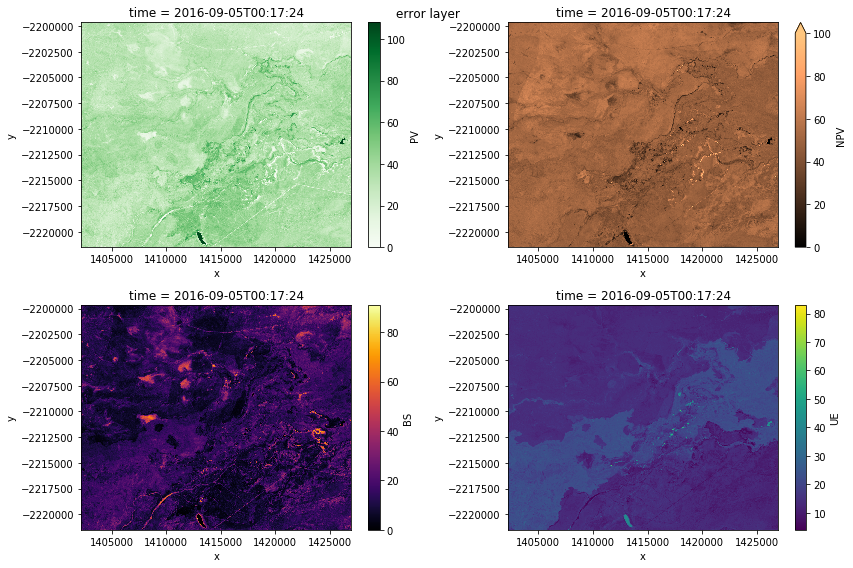

In [35]:
plt.clf()
plt.figure(figsize=(12,8))
#set up a grid of 3 images for better presentation
gs = gridspec.GridSpec(2,2)
#fig =plt.figure(figsize =(9,3))

#_______________________________________________________________#
ax1=plt.subplot(gs[0,0])
sensor3_fc.PV.isel(time=timechosen).plot(cmap='Greens')

ax2=plt.subplot(gs[1,0])
sensor3_fc.BS.isel(time=timechosen).plot(cmap='inferno')

ax3=plt.subplot(gs[0,1])
sensor3_fc.NPV.isel(time=timechosen).plot(cmap='copper',vmax=100,vmin=0)

ax4=plt.subplot(gs[1,1])
plt.suptitle('error layer')
sensor3_fc.UE.isel(time=timechosen).plot()

plt.tight_layout()
plt.show()

## Load wofs data

In [36]:
#get wofs
wofs = load_wofs(query)

loaded wofs for query{'time': ('2014-01-01', '2017-12-31'), 'geopolygon': Geometry(POLYGON ((145.489470367818 -20.0295617688342,145.467427894673 -19.8344546925194,145.703268985975 -19.8108314846604,145.725691564259 -20.0059100843174,145.489470367818 -20.0295617688342)), GEOGCS["GCS_WGS_1984",DATUM["WGS_1984",SPHEROID["WGS_84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]])}


## Print wofs metadata

In [37]:
for key in wofs.water.flags_definition.keys():
    print('{}  {}'.format(key, wofs.water.flags_definition[key]))

dry  {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'0': True}, 'description': 'No water detected'}
sea  {'bits': 2, 'values': {'0': False, '1': True}, 'description': 'Sea'}
wet  {'bits': [7, 6, 5, 4, 3, 1, 0], 'values': {'128': True}, 'description': 'Clear and Wet'}
cloud  {'bits': 6, 'values': {'0': False, '1': True}, 'description': 'Cloudy'}
nodata  {'bits': 0, 'values': {'1': True}, 'description': 'No data'}
high_slope  {'bits': 4, 'values': {'0': False, '1': True}, 'description': 'High slope'}
cloud_shadow  {'bits': 5, 'values': {'0': False, '1': True}, 'description': 'Cloud shadow'}
noncontiguous  {'bits': 1, 'values': {'0': False, '1': True}, 'description': 'At least one EO band is missing over over/undersaturated'}
terrain_or_low_angle  {'bits': 3, 'values': {'0': False, '1': True}, 'description': 'terrain shadow or low solar angle'}


## calculate wofs proportion

In [38]:
wofs_drop = wofs.where(wofs.time == sensor3_fc.time)
wofs_proportion, dry_proportion = wofs_water_or_land(wofs_drop)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


## Plot wofs proportion

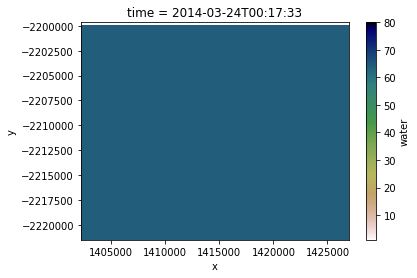

In [39]:
plt.clf()
wofs.water.isel(time=5).plot(cmap='gist_earth_r')

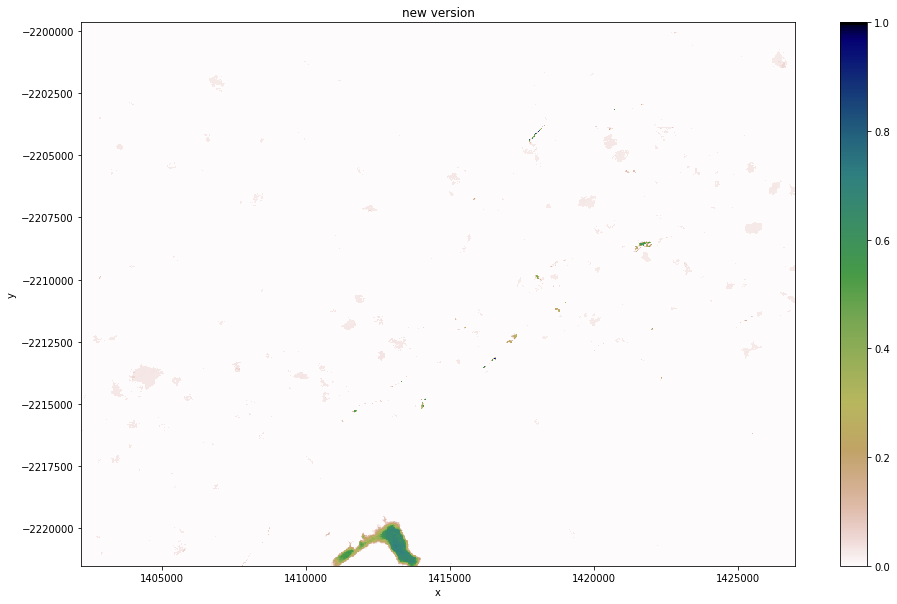

In [40]:
plt.clf()
plt.figure(figsize=(16,10))
wofs_proportion.plot(vmin=0, vmax =1, cmap ='gist_earth_r')
plt.title('new version')
plt.show()

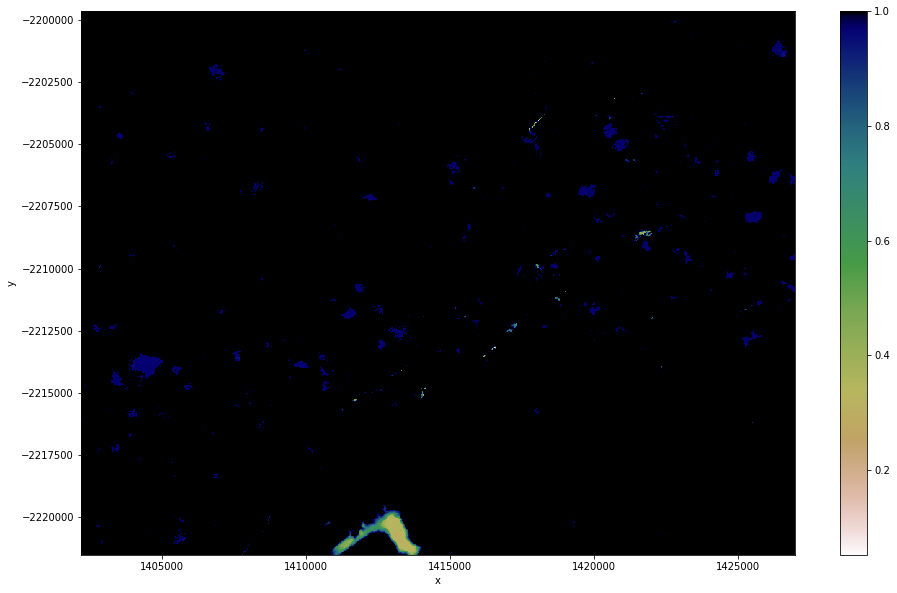

In [41]:
plt.clf()
plt.figure(figsize=(16,10))
dry_proportion.plot(cmap ='gist_earth_r')
plt.show()

## Calculate fractional cover bare soil count of exceedence 

In [42]:
bare_over_thresh =calc_bare_soil_overthresh(sensor3_fc)

thresholded bare_soil added to array


In [43]:
bare_count_of_ex_sensor3,bcounts_sensor_3_fc = count_fc_1sensor(bare_over_thresh,'BS','bare_soil_over_threshold')

counted


## Plot bare soil count of exceedence

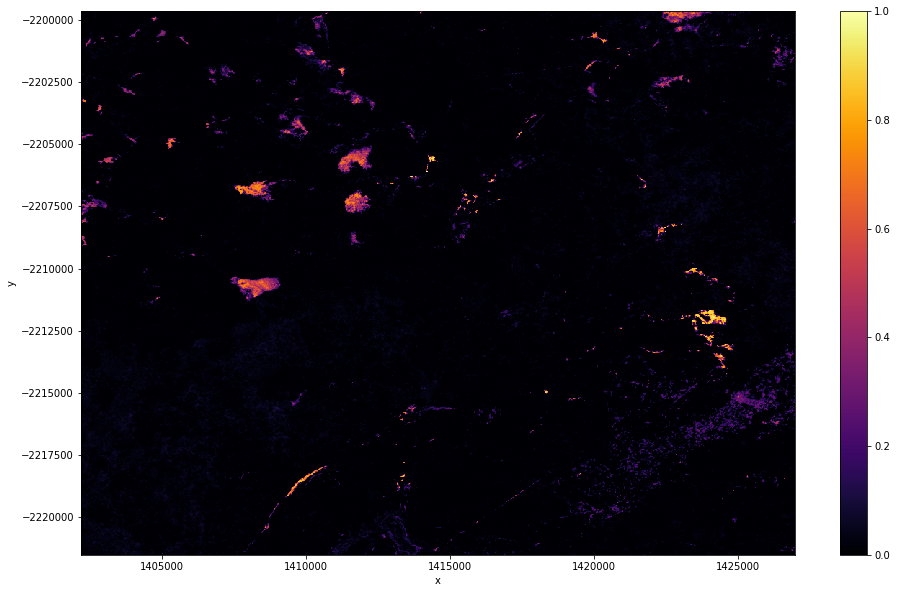

In [44]:
plt.clf()
plt.figure(figsize=(16,10))
bare_count_of_ex_sensor3.plot(cmap='inferno',vmin=0, vmax=1)
plt.show()

## Calculate photosynthetic vegetation count of exceedence

In [45]:
green_overthresh = calc_green_veg_overthresh(sensor3_fc)

thresholded green_veg added to array


In [46]:
green_veg_count_of_ex_sensor3,gcounts_sensor_3_nbart = count_fc_1sensor(green_overthresh, 'PV','green_veg_over_threshold')

counted


## Plot green_veg count of exceedence

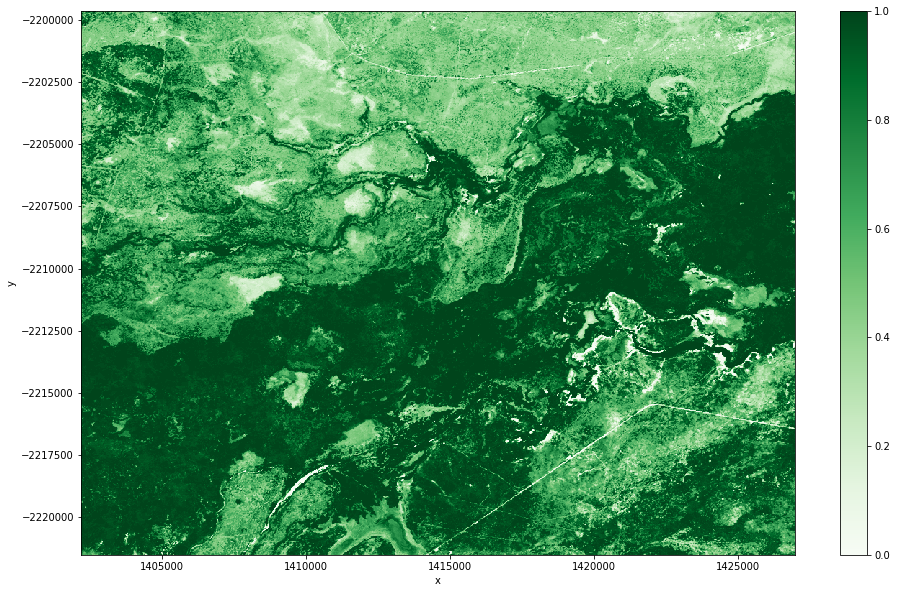

In [47]:
plt.clf()
plt.figure(figsize=(16,10))
green_veg_count_of_ex_sensor3.plot(cmap='Greens')
plt.show()

In [48]:
# if sensor1_nbart is not None:
#     crs = sensor1_nbart.crs
# else:
#     if sensor2_nbart is not None:
#         crs = sensor2_nbart.crs
#     else: 
crs = sensor3_fc.crs
print(crs) 

EPSG:3577


## Write out CoE arrays to netcdf

##### choose filenames and check where we are saving our files

In [49]:
print(netcdf_output_loc)

/g/data/r78/rjd547/groundwater_activities/Analysis/Fractional_Cover/


In [50]:
filenamestart = netcdf_output_loc+shape_name
print (filenamestart)

/g/data/r78/rjd547/groundwater_activities/Analysis/Fractional_Cover/nulla2_0


In [51]:
#option to add date range to filename
filenamestart_epoch=filenamestart+'_'+start_of_epoch+'_'+end_of_epoch

In [52]:
filenamestart_epoch

'/g/data/r78/rjd547/groundwater_activities/Analysis/Fractional_Cover/nulla2_0_2014-01-01_2017-12-31'

In [53]:
write_your_netcdf(wofs_proportion,'tcw_ls8',filename=filenamestart_epoch+'_wofs_v2_coe_s3'+'.nc', crs=crs)

In [54]:
write_your_netcdf(bare_count_of_ex_sensor3,'tcb_ls8',filename=filenamestart_epoch+'_bare_soil_coe_s3'+'.nc', crs=crs)

In [55]:
write_your_netcdf(green_veg_count_of_ex_sensor3,'tcg_ls8',filename=filenamestart_epoch+'_green_veg_coe_s3'+'.nc', crs=crs)

In [56]:
os.chdir(netcdf_output_loc)

In [57]:
os.listdir()

['new_moon_inlet_0_2014-01-01_2017-12-31_wofs_v2_coe_s3.tif',
 'arafura_sw_0_2014-01-01_2017-12-31_bare_soil_coe_s3.tif',
 'arafura_sw_0_2014-01-01_2017-12-31_green_veg_coe_s3.nc',
 'arafura_sml_0_2014-01-01_2017-12-31_bare_soil_coe_s3.tif',
 'arafura_sml_0_2014-01-01_2017-12-31_bare_soil_coe_s3.nc',
 'vic_river_0_2014-01-01_2017-12-31_wofs_v2_coe_s3.tif',
 'arafura_sml_0_2014-01-01_2017-12-31_green_veg_coe_s3.tif',
 'nulla2_0_2014-01-01_2017-12-31_wofs_v2_coe_s3.nc',
 'vic_river_0_2014-01-01_2017-12-31_bare_soil_coe_s3.tif',
 'kinrara_bs_0_2014-01-01_2017-12-31_wofs_v2_coe_s3.nc',
 'arafura_sml_0_2014-01-01_2017-12-31_bare_soil_coe_s3.tif.aux.xml',
 'vic_river_0_2014-01-01_2017-12-31_bare_soil_coe_s3.nc',
 'w_arnhem_0_2014-01-01_2017-12-31_bare_soil_coe_s3.nc',
 'new_moon_inlet_0_2014-01-01_2017-12-31_bare_soil_coe_s3.tif',
 'w_arnhem_0_2014-01-01_2017-12-31_wofs_v2_coe_s3.nc',
 'lake_gregory_0_2014-01-01_2017-12-31_green_veg_coe_s3.tif',
 'lake_gregory_0_2014-01-01_2017-12-31_wofs_v2

In [39]:
def load_something(sensor, other_stuff):
    return {'sensor': sensor, 'other': other_stuff}

In [459]:
sensor1 = load_something('ls5', [])
sensor2 = load_something('ls8', [])
sensor3 = load_something('ls7', [])

In [460]:
sensor = [load_something(sensor, []) for sensor in ['ls5', 'ls7', 'ls8']]

In [461]:
sensor

[{'other': [], 'sensor': 'ls5'},
 {'other': [], 'sensor': 'ls7'},
 {'other': [], 'sensor': 'ls8'}]

In [464]:
tmp = [(i, j) for i in range(10)
              for j in range(10)
              if i + j == 4]

In [463]:
tmp

[(0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]

In [465]:
from collections import namedtuple

In [466]:
SomeType = namedtuple('SomeType', ['BS', 'PV', 'NPV'])

In [467]:
a = SomeType(BS=0, PV=1, NPV=3)

In [470]:
for name in ['BS', 'PV', 'NPV']:
    print(getattr(a, name))

0
1
3


In [471]:
tmp

[(0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]

In [472]:
tmp.pop()

(4, 0)

In [474]:
getattr(tmp, 'pop')()

(3, 1)